In [1]:
import sys
sys.path.append('../')
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from notebooks.notebook_setup import device, smooth_graph, create_new_set_of_models, train_models_and_get_histories, update_dict
from ocd.models.oslow import OSlowTest
from ocd.data.synthetic.graph_generator import GraphGenerator
from ocd.data.synthetic.utils import RandomGenerator
from ocd.data.synthetic.parametric import AffineParametericDataset
from ocd.data.synthetic.nonparametric import AffineNonParametericDataset
from ocd.models.normalization import ActNorm
from ocd.training.trainer import Trainer
from ocd.config import GumbelTopKConfig, BirkhoffConfig, GumbelSinkhornStraightThroughConfig, ContrastiveDivergenceConfig
from tqdm import tqdm
import numpy as np

%load_ext autoreload
%autoreload 2
device = 'cuda:1'
print(device)

num_samples = 128
permutation_batch_size = 128
flow_batch_size = 128
epochs = 500
flow_lr = 0.0001
perm_lr = 0.000001
flow_freq = 1
perm_freq = 0
num_nodes = 4

graph_generator = GraphGenerator(
    num_nodes=num_nodes,
    seed=12,
    graph_type="full",
    enforce_ordering=[i for i in range(num_nodes)],
)
graph = graph_generator.generate_dag()

# These generators are also needed to generate the data
gaussian_noise_generator = RandomGenerator('normal', seed=30, loc=0, scale=1)
link_generator = RandomGenerator('uniform', seed=1100, low=1, high=1)

# parameteric with sin(x) + x non-linearity and softplus
dset_sinusoidal = AffineParametericDataset(
    num_samples=num_samples,
    graph=graph,
    noise_generator=gaussian_noise_generator,
    link_generator=link_generator,
    link="sinusoid",
    perform_normalization=False,
)
class CustomTensorDataset(torch.utils.data.Dataset):
    r"""Dataset wrapping tensors.

    Each sample will be retrieved by indexing tensors along the first dimension.

    Args:
        *tensors (Tensor): tensors that have the same size of the first dimension.
    """

    def __init__(self, tensor: torch.Tensor) -> None:
        self.tensor = tensor

    def __getitem__(self, index):
        return self.tensor[index]

    def __len__(self):
        return len(self.tensor)


dataset = CustomTensorDataset(torch.tensor(dset_sinusoidal.samples.values).float())
flow_dataloader = DataLoader(dataset, batch_size=flow_batch_size, shuffle=True)
permutation_dataloader = DataLoader(dataset, batch_size=permutation_batch_size, shuffle=True)

cuda:1


In [2]:
%autoreload 2

from ocd.visualization.birkhoff import get_all_permutation_matrices
from ocd.models.oslow import OSlow
import wandb

torch.random.manual_seed(101)
model = OSlow(in_features=num_nodes,
              layers=[128, 64, 128],
              dropout=None,
              residual=False,
              activation=torch.nn.LeakyReLU(),
              additive=False,
              num_transforms=1,
              normalization=ActNorm,
              base_distribution=torch.distributions.Normal(loc=0, scale=1),
              ordering=None)


def flow_optimizer(params): return torch.optim.AdamW(params, lr=flow_lr)
def perm_optimizer(params): return torch.optim.AdamW(params, lr=perm_lr)


permutation_learning_config = GumbelTopKConfig(
    num_samples=num_samples,
    buffer_size=10,
    buffer_update=10,
    set_gamma_custom=[
      [0, 1, 2, 3]
    ]
)


# permutation_learning_config = GumbelSinkhornStraightThroughConfig(temp=0.1, iters=20)
temperature_scheduler = 'constant'
temperature = 0.0

birkhoff_config = None if num_nodes > 4 else BirkhoffConfig(
    num_samples=100, frequency=500, print_legend=False)
trainer = Trainer(model=model,
                  dag=graph,
                  flow_dataloader=flow_dataloader,
                  perm_dataloader=permutation_dataloader,
                  flow_optimizer=flow_optimizer,
                  permutation_optimizer=perm_optimizer,
                  flow_frequency=flow_freq,
                  temperature=temperature,
                  temperature_scheduler=temperature_scheduler,
                  permutation_frequency=perm_freq,
                  max_epochs=epochs,
                  flow_lr_scheduler=torch.optim.lr_scheduler.ConstantLR,
                  permutation_lr_scheduler=torch.optim.lr_scheduler.ConstantLR,
                  permutation_learning_config=permutation_learning_config,
                  birkhoff_config=birkhoff_config,
                  device=device)
wandb.init(project="notebooks", entity="ordered-causal-discovery",
           name='separate0123',
            tags=[
                permutation_learning_config.method,
                f"num_nodes-{num_nodes}",
                f"epochs-{epochs}",
                f"base-temperature-{temperature}",
                f"temperature-scheduling-{temperature_scheduler}",
                "no-sigmoid",
            ],)
trainer.train()
wandb.finish()

2024-02-08 03:07:28 ERROR    Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hamidrezakamkari (ordered-causal-discovery). Use `wandb login --relogin` to force relogin


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
flow/loss,████▇▇▇▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
flow/step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
permutation/temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,499
flow/loss,10.48601
flow/step,500
permutation/temperature,0.0


Permutation: 0123
Log Prob: -10.487903594970703
Backward count: 0.0

-----
Permutation: 0132
Log Prob: -45.52796936035156
Backward count: 0.16666666666666666

-----
Permutation: 0213
Log Prob: -14169.421875
Backward count: 0.16666666666666666

-----
Permutation: 0231
Log Prob: -417746.71875
Backward count: 0.3333333333333333

-----
Permutation: 0312
Log Prob: -13.24649429321289
Backward count: 0.3333333333333333

-----
Permutation: 0321
Log Prob: -12.935531616210938
Backward count: 0.5

-----
Permutation: 1023
Log Prob: -4530.3759765625
Backward count: 0.16666666666666666

-----
Permutation: 1032
Log Prob: -4537.21240234375
Backward count: 0.3333333333333333

-----
Permutation: 1203
Log Prob: -1465733.75
Backward count: 0.3333333333333333

-----
Permutation: 1230
Log Prob: -454388.6875
Backward count: 0.5

-----
Permutation: 1302
Log Prob: -14.005182266235352
Backward count: 0.5

-----
Permutation: 1320
Log Prob: -13.500919342041016
Backward count: 0.6666666666666666

-----
Permutation

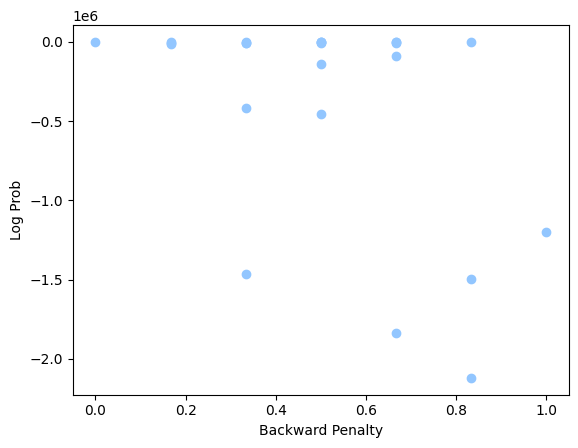

In [3]:
%autoreload 2

from ocd.visualization.birkhoff import get_all_permutation_matrices
from ocd.evaluation import backward_relative_penalty

all_perms = get_all_permutation_matrices(4)

all_scores = []
all_backward = []
with torch.no_grad():
  for perm in all_perms:
        perm = perm.float().to(device)
        all_log_probs = []
        for x in flow_dataloader:
              x = x.to(device)
              all_log_probs.append(model.log_prob(x, perm.unsqueeze(0).repeat(x.shape[0], 1, 1)).mean().item())
        perm_list = [x for x in torch.argmax(perm, dim=1).cpu().numpy().tolist()]
        perm_list_formatted = ''.join([str(x) for x in perm_list])
        score = sum(all_log_probs) / len(all_log_probs)
        backward = backward_relative_penalty(perm_list, graph)
        all_scores.append(score)
        all_backward.append(backward)
        print(f"Permutation: {perm_list_formatted}\nLog Prob: {score}\nBackward count: {backward}\n")
        print("-----")

import matplotlib.pyplot as plt

plt.scatter(all_backward, all_scores)
plt.xlabel("Backward Penalty")
plt.ylabel("Log Prob")
plt.show()